# Optical flow, motion tracking, segmentation, stereo vision
Erik Matovič  
A solution inspired by [Open CV optical flow tutorial](https://docs.opencv.org/4.x/d4/dee/tutorial_optical_flow.html)   


In [1]:
from typing import Tuple
import cv2
import numpy as np
from matplotlib import pyplot as plt
#from utils import show_img, resize_img, calc_histogram_show, plt_img, equalize_hist, gamma_coorection

print(cv2.__version__)

4.7.0


## Sparse optical flow

Visualize trajectories of moving objects.

Optional task: Identify each object using a bounding box and count them.

Use following functions: cv::goodFeaturesToTrack, cv::calcOpticalFlowPyrLK

In [2]:
def get_cap_out(video_path:str, out_root:str='..', start_idx:int=15) -> Tuple[cv2.VideoCapture,
                                                                              cv2.VideoWriter]:
    """
    Read video capture and make video writer.
    :param video_path:  path of the input 
    :param out_root:    path of the output folder
    :param start_idx:   index for the name of the output video 
    returns: cv2.VideoCapture, cv2.VideoWriter 
    """
    # load video
    cap = cv2.VideoCapture(video_path)

    # convert the resolutions from float to integer.
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    # make video writer
    out = cv2.VideoWriter(out_root + video_path[start_idx:-4] + '.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
    return cap, out

In [4]:
def sparse_optical_flow(cap: cv2.VideoCapture, out: cv2.VideoWriter, 
                        ShiTomasi_params: dict, pyrLK_params: dict) -> None:
    """
    Sparse optical flow with only 1 Shi-Tomasi Corner Detection and 
    computation via Lucas-Kanade Optical Flow between previous and current frame.
    """
    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    # Shi-Tomasi Corner Detection
    corners = cv2.goodFeaturesToTrack(old_gray, **ShiTomasi_params)

    # mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    # list of random colors
    color = np.random.randint(0, 255, (100, 3))

    # Lucas-Kanade Optical Flow
    ret, frame = cap.read()
    while(ret):
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        # nextPts = 2D next points
        # st = status vector, 1 if the the corresponding features has been found
        nextPts, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, corners, None, **pyrLK_params)
        
        # Select good points based on status
        if nextPts is not None:
            good_new = nextPts[st==1]
            good_old = corners[st==1]

        # draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):

            # reuse the color vector, if it is too short
            if i >= len(color):
                  i %= 10 

            a, b = new.ravel()
            c, d = old.ravel()
            pt1, pt2 = (int(a), int(b)), (int(c), int(d))
            mask = cv2.line(mask, pt1, pt2, color[i].tolist())
        img = cv2.add(frame, mask)
        
        # write the flipped frame
        out.write(img)
        
        # update the previous frame and previous points
        old_gray = frame_gray.copy()
        corners = good_new.reshape(-1, 1, 2)

        # read next frame
        ret, frame = cap.read()
        
    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [25]:
def sparse_optical_flow2(cam: cv2.VideoCapture, out: cv2.VideoWriter,
        ShiTomasi_params: dict, pyrLK_params: dict,
        frame_interval: int=5, good_threshold:int=1) -> None:
    """ 
    Sparse optical flow with Shi-Tomasi Corner Detection updating in every five frames. 
    Lucas-Kanade Optical Flow computation done between the previous and current frame 
    and the current and previous frame. We use threshold filtering after Euclidian distance 
    computation between two optical flows to choose appropriate tracking points.
    We have also manipulated a mask and skipped the upper third of a region of interest 
    because the movement in the sky is not expected.
    """
    frame_counter = 0
    tracks = list()

    # first frame
    ret, old_frame = cam.read()
    prev_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    # next frame
    ret, frame = cam.read()
    while ret:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # update the existing tracks by performing optical flow analysis
        if len(tracks) > 0:
            # array of shape (num_tracks, 1, 2) containing the last known positions of each track
            p0 = np.float32([track[-1] for track in tracks]).reshape(-1, 1, 2)
            
            # optical flow between previous and next frame with p0 as the starting point
            p1, _st, _err = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, p0, None, **pyrLK_params)
            
            # check the correctness of the calculated optical flow
            # optical flow between next and previous frame with p1 as the starting point
            p0_check, _st, _err = cv2.calcOpticalFlowPyrLK(frame_gray, prev_gray, p1, None, **pyrLK_params)

            # Euclidean distance d between p0 and p0_check for each track, 
            # store it in an array of shape (num_tracks,)
            # check if the calculated optical flow is accurate
            # if the distance is too large, it indicates that the optical flow 
            # calculation is incorrect and the track should be discarded            
            d = abs(p0 - p0_check).reshape(-1, 2).max(-1)

            # boolean array of shape (num_tracks,)
            # good[i] is True if the distance d[i] is less than a threshold value of 1, 
            # indicating that the optical flow calculation is accurate
            # good is used to filter out tracks that have inaccurate optical flow.
            good = d < good_threshold

            new_tracks = []

            # loop through each track and its new position p1, and good flag
            for track, (x, y), good_flag in zip(tracks, p1.reshape(-1, 2), good):
                # skip tracks not corresponding with threshold
                if not good_flag:
                    continue
                # if good is True, append the new position to the track
                track.append((x, y))
                # delete the oldest position if the track length exceeds the number of tracks.
                if len(track) > len(tracks):
                    del track[0]
                new_tracks.append(track)
            tracks = new_tracks
            
            # connects the points in each track
            cv2.polylines(frame, [np.int32(tr) for tr in tracks], False, (0, 255, 0), thickness=1)

        # update ShiTomasi corner detection
        if frame_counter % frame_interval == 0:
            mask = np.zeros_like(frame_gray)

            # mask with skipped ROI 1/3 from up(movement in the sky is not expected)
            frame_height = int(cam.get(4))
            mask[int(frame_height / 3):][:] = 255
            corners = cv2.goodFeaturesToTrack(frame_gray, mask=mask, **ShiTomasi_params)
            
            # update points in tracker
            if corners is not None:
                #tracks = list()
                for x, y in np.float32(corners).reshape(-1, 2):
                    tracks.append([(x, y)])

        frame_counter += 1
        prev_gray = frame_gray

        # next frame
        out.write(frame)
        ret, frame = cam.read()

    # Release everything if job is finished
    cam.release()
    out.release()
    cv2.destroyAllWindows()

In [27]:
out_root = '../sparse_optical_flow'
ShiTomasi_params = dict(#mask = None, 
    maxCorners = 1000,         # max number of corners to return
    qualityLevel = 0.3,       # min accepted quality of img corners
    minDistance = 5,           # min possible Euclidean distance between the returned corners
    blockSize = 5,             # size of an average block for computing a derivative covariation matrix over each pixel neighborhood
    useHarrisDetector = False 
)

pyrLK_params = dict(winSize  = (41, 41),   # size of the search window at each pyramid lvl
                 maxLevel = 4,          # max pyramid level number
                 # termination criteria
                 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

cap, out = get_cap_out('../data/archive/fourway.avi', out_root)
#sparse_optical_flow(cap, out, ShiTomasi_params, pyrLK_params)
sparse_optical_flow2(cap, out, ShiTomasi_params, pyrLK_params, 15, 1)

In [28]:
ShiTomasi_params = dict(mask = None, 
    maxCorners = 10000,         # max number of corners to return
    qualityLevel = 0.1,       # min accepted quality of img corners
    minDistance = 1,           # min possible Euclidean distance between the returned corners
    blockSize = 1,             # size of an average block for computing a derivative covariation matrix over each pixel neighborhood
    useHarrisDetector = False 
)

pyrLK_params = dict(winSize  = (41, 41),   # size of the search window at each pyramid lvl
                 maxLevel = 4,          # max pyramid level number
                 # termination criteria
                 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
cap, out = get_cap_out('../data/archive/crosswalk.avi', out_root)
sparse_optical_flow(cap, out, ShiTomasi_params, pyrLK_params)

In [29]:
ShiTomasi_params = dict(mask = None, 
    maxCorners = 10000,         # max number of corners to return
    qualityLevel = 0.1,       # min accepted quality of img corners
    minDistance = 1,           # min possible Euclidean distance between the returned corners
    blockSize = 1,             # size of an average block for computing a derivative covariation matrix over each pixel neighborhood
    useHarrisDetector = False 
)

pyrLK_params = dict(winSize  = (41, 41),   # size of the search window at each pyramid lvl
                 maxLevel = 4,          # max pyramid level number
                 # termination criteria
                 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

cap, out = get_cap_out('../data/archive/night.avi', out_root)
sparse_optical_flow(cap, out, ShiTomasi_params, pyrLK_params)

In [30]:
ShiTomasi_params = dict(#mask = None, 
    maxCorners = 10000,         # max number of corners to return
    qualityLevel = 0.1,       # min accepted quality of img corners
    minDistance = 1,           # min possible Euclidean distance between the returned corners
    blockSize = 1,             # size of an average block for computing a derivative covariation matrix over each pixel neighborhood
    useHarrisDetector = False 
)

pyrLK_params = dict(winSize  = (41, 41),   # size of the search window at each pyramid lvl
                 maxLevel = 4,          # max pyramid level number
                 # termination criteria
                 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

cap, out = get_cap_out('../data/JAAD/video_0028.mp4', out_root, -15)
ret, old_frame = cap.read()
sparse_optical_flow(cap, out, ShiTomasi_params, pyrLK_params)

## Dense optical flow

Identify moving objects in video and draw green rectangle around them.

Use downsampled video for this task if necessary for easier processing.

Use following functions: cv::calcOpticalFlowFarneback

[OpenCV's tutorial on how to optical flow](https://docs.opencv.org/4.x/d4/dee/tutorial_optical_flow.html)

night si skús cez gammu roztiahnut pre lepšiu vizualizáciu

In [43]:
import random as rng
rng.seed(12345)

def dense_optical_flow(cap: cv2.VideoCapture, out: cv2.VideoWriter,
                       farneback_params: dict) -> None:
    ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255
    ret, frame2 = cap.read()
    while(ret):
        next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        # dense optical flow by Farneback method
        flow = cv2.calcOpticalFlowFarneback(
            prev=prvs,      # first 8-bit single-channel input image 
            next=next,      # second input img with the same size and the same type as prev
            **farneback_params)
        #print(flow[..., 0], flow[..., 1])
        flow[..., 0]
        flow[..., 1]
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        mag = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)
        #print(flow.shape)
        # img hue according to the optical flow direction
        hsv[..., 0] = (ang * 180) / (2 * np.pi)
        # img value according to the normalized optical flow magnitude
        #print('pred:\n', mag)
        hsv[..., 2] = cv2.normalize(mag, None, 0.0, 255.0, cv2.NORM_MINMAX)
        #hsv = cv.rectangle(hsv, pt1, pt2, color[, thickness[, lineType[, shift]]])
        # Convert HSV to BGR
        #print('po:\n', hsv[..., 2])
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        #print('BGR:\n', bgr)
        #cv.imshow('frame2', bgr)
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

        # Create a binary mask using the threshold value
        _, mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
        #resize = cv2.resize(mask, (600, 400))
        #cv2.imshow('frame2', resize)
        #cv2.waitKey(0)
        # Apply morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)) #np.ones((5, 5), np.uint8)
        #resize = cv2.resize(kernel, (600, 400))
        #cv2.imshow('frame2', resize)
        #cv2.waitKey(0)
        canny = cv2.Canny(gray, 0, 50)
        #dilated = cv2.dilate(canny, (1, 1), iterations=0)
        #dilated = cv2.dilate(mask.astype(np.uint8), kernel, iterations=2)
        dilated = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
        #resize = cv2.resize(dilated, (600, 400))
        #cv2.imshow('frame2', resize)
        #cv2.waitKey(0)

        dilated = cv2.dilate(dilated, kernel, iterations=2)
        #dilated = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
        #resize = cv2.resize(dilated, (600, 400))
        #cv2.imshow('frame2', resize)
        #cv2.waitKey(0)

        dilated = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
        #resize = cv2.resize(dilated, (600, 400))
        #cv2.imshow('frame2', resize)
        #cv2.waitKey(0)
        (contours, hierarchy) = cv2.findContours(
            dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #print(contours)

        # loop over the contours
        #for contour in contours:
        #    (x, y, w, h) = cv2.boundingRect(contour)
            # if the contour is too small, ignore it
        #    if w > 10 and h > 10 and w < 900 and h < 680:
        #        cv2.rectangle(bgr, (x, y), (x + w, y + h), (0, 255, 0), 4)
        #        cv2.putText(bgr, 'test', (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),1)

        # Approximate contours to polygons + get bounding rects and circles
        #contours_poly = [None]*len(contours)
        #boundRect = [None]*len(contours)
        #centers = [None]*len(contours)
        #radius = [None]*len(contours)
        for i, c in enumerate(contours):
            # Calculate area and remove small elements
            #area = cv2.contourArea(c)
            #if area < 10:
            #    continue
            #contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            #boundRect[i] = cv2.boundingRect(contours_poly[i])
            (x, y, w, h) = cv2.boundingRect(c)
            #print(x, y, w, h)
            if w * h < 60000: #w < 50 or h < 50 or w > 900 or h > 800:
                continue
            color = (0, 255, 0) #(rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            #cv2.drawContours(bgr, contours_poly, i, color)
            cv2.rectangle(frame2, (x, y), (x + w, y + h), color, 2)
            #resize = cv2.resize(frame2, (600, 400))
            #cv2.imshow('frame2', resize)
            #cv2.waitKey(0)
            #break
        #break
            #centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])
            # Draw polygonal contour + bonding rects + circles
        #for i in range(len(contours)):
            # Calculate area and remove small elements
        #    (x, y, w, h) = boundRect[i]
        #    if w < 25 or h < 25 or w > 900 or h > 800:
        #        continue
        #    color = (0, 255, 0) #(rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            #cv2.drawContours(bgr, contours_poly, i, color)
        #    cv2.rectangle(frame1, (x, y), (x + w, y + h), color, 2)
            #bgr = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #cv2.rectangle(bgr, (x1, y1), (x2, y2), (255,0,0), 2)
        #cv2.drawContours(bgr, contours, -1, (0, 255, 0), 2)
        #bgr_resize = cv2.resize(frame1, (600, 400))
        #cv2.imshow('frame2', bgr_resize)
        #cv2.waitKey(0)
        #break
        out.write(frame2)
        prvs = next
        ret, frame2 = cap.read()
    cv2.destroyAllWindows()

In [44]:
out_root = '../dense_optical_flow'
cap, out = get_cap_out('../data/archive/fourway.avi', out_root)

farneback_params = dict(
            flow=None,      # computed flow image, not needed, because it is returned 
            pyr_scale=0.5,  # img scale to build pyramids for each image; pyr_scale=0.5 -> each next layer is twice smaller than the previous. 
            levels=3,       # number of pyramid layers including the initial image   
            winsize=41,     # larger values increase the robustness to image noise  
            iterations=5,   # number of iterations the algorithm does at each pyramid level
            poly_n=5,       # size of the pixel neighborhood; larger values mean that the image will be approximated with smoother surfaces, more robust algorithm and more blurred motion field. 
            poly_sigma=1.5, # standard deviation of the Gaussian 
            flags=0         # operation flags
)
dense_optical_flow(cap, out, farneback_params)

In [ ]:
def process_video(cap, out, params):
    #cap = cv2.VideoCapture(video_path)

    # Read the first frame
    ret, prev_frame = cap.read()
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    # Loop through the video frames
    while True:
        # Read the current frame
        ret, curr_frame = cap.read()
        if not ret:
            break

        # Convert the current frame to grayscale
        curr_frame_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

        # Calculate dense optical flow
        #flow = get_optical_flow(prev_frame_gray, curr_frame_gray)
        flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, curr_frame_gray, None, **params)

        # Threshold the flow magnitude to detect moving pixels
        #mask = threshold_flow_mag(flow, threshold=15)
        mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        mask = mag > 15
        mask = mask.astype(np.uint8)

        # Get the contours of the moving objects
        #contours, hierarchy = get_contours(mask)
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw rectangles around the moving objects
        #frame_with_rectangles = draw_rectangles(cur_frame, contours)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(curr_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Display the frame with rectangles
        cv2.imshow('Moving objects detection', curr_frame)

        # Exit if the user presses 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Set the current frame as the previous frame for the next iteration
        prev_frame_gray = curr_frame_gray

    # Release the video capture object and destroy all windows
    cap.release()
    cv2.destroyAllWindows()

Motion tracking Datasets

Feel free to experiment with multiple videos for motion tracking. Use the following link for additional datasets - https://motchallenge.net/data/MOT15/

## Segmentation using background subtraction

Use background substraction methods to properly segment the moving objects from their background. Use one of the videos with static camera.

Use the following approaches:

    Accumulated weighted image

    Mixture of Gaussian (MOG2)

In [3]:
def MOG2(cap: cv2.VideoCapture, video_path: str, MOG2_params:dict, start_idx:int=15):# -> None:
    # make video writer
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    out = cv2.VideoWriter(out_root + video_path[start_idx:-4] + '.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height), isColor=False)
    
    backSub = cv2.createBackgroundSubtractorMOG2(**MOG2_params)
    ret, frame = cap.read()
    count = 0
    while(ret):
        mask = backSub.apply(frame)
        
        cv2.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv2.putText(frame, str(cap.get(cv2.CAP_PROP_POS_FRAMES)), (15, 15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        #frame_resize = cv2.resize(frame, (600, 400))
        #mask__resize = cv2.resize(mask, (600, 400))

        count += 1
        #if count % 100:
        #    cv2.imshow('Frame', frame_resize)
        #    cv2.imshow('FG Mask', mask__resize)
            #cv2.imshow('frame2', bgr_resize)
        #    cv2.waitKey(0)
        #    break
        
        out.write(mask)
        ret, frame = cap.read()
    cv2.destroyAllWindows()

In [5]:
out_root = '../MOG2'
cap, out = get_cap_out('../data/archive/crosswalk.avi', out_root)


MOG2_params = dict(
    history=100, 
    varThreshold=40, 
    detectShadows=False
)
MOG2(cap, '../data/archive/crosswalk.avi', MOG2_params)

accumulated_weighted_image
 - rozdiel medzi curr a accumulated_weighted_image
 - vhodné na dlhé videá

In [9]:
def accumulated_weighted_image(cap: cv2.VideoCapture, out: cv2.VideoWriter, alpha=0.1) -> None:
    """
    :param cap: video capture
    :param out: video writer
    :param alpha: regulates the update speed, how fast the accumulator “forgets” about earlier images. 
        - if alpha is a higher value, average image tries to catch even very fast and short changes in the data. 
        - if it is lower value, average becomes won't consider fast changes in the input images
    """
    ret, frame = cap.read()
    count = 0

    avg1 = np.float32(frame)
    avg2 = np.float32(frame)

    while(ret):
        cv2.accumulateWeighted(src=frame, dst=avg1, alpha=alpha)
        #cv2.accumulateWeighted(src=frame, dst=avg2, alpha=0.01)

        # scaling, taking an absolute value, conversion to an unsigned 8-bit type: 
        avg_img = cv2.convertScaleAbs(avg1)
        #res2 = cv2.convertScaleAbs(avg2)
        
        #cv2.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        #cv2.putText(frame, str(cap.get(cv2.CAP_PROP_POS_FRAMES)), (15, 15),
        #        cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        frame_resize = cv2.resize(frame, (600, 400))
        avg_img_resize = cv2.resize(avg_img, (600, 400))

        #count += 1
        #if count % 100:
        #    cv2.imshow('Frame', frame_resize)
        #    cv2.imshow('avg1', avg1_resize)
        #    cv2.imshow('avg2', avg2_resize)
        #    cv2.waitKey(0)
        #    break

        out.write(avg_img)
        ret, frame = cap.read()
    cv2.destroyAllWindows()

In [11]:
out_root = '../accumulated_weighted_image'
cap, out = get_cap_out('../data/archive/fourway.avi', out_root)

accumulated_weighted_image(cap, out, alpha=2)

In [13]:
out_root = '../accumulated_weighted_image'
cap, out = get_cap_out('../data/archive/fourway.avi', out_root)

accumulated_weighted_image(cap, out, alpha=1.1)

In [14]:
out_root = '../accumulated_weighted_image'
cap, out = get_cap_out('../data/archive/fourway.avi', out_root)

accumulated_weighted_image(cap, out, alpha=0.5)

In [15]:
out_root = '../accumulated_weighted_image'
cap, out = get_cap_out('../data/archive/fourway.avi', out_root)

accumulated_weighted_image(cap, out, alpha=0.1)

In [16]:
out_root = '../accumulated_weighted_image'
cap, out = get_cap_out('../data/archive/fourway.avi', out_root)

accumulated_weighted_image(cap, out, alpha=0.01)

## Grab Cut segmentation

Propose a simple method to segment a rough estimate of lateral ventricle segmentation using morphological processing and thresholding.

[Link, 5 x PNG, 137 KB](https://drive.google.com/file/d/1hnQ_PHx0LhMNCMlpwCFhXVx4fFl9j_Aq/view) 

Use OpenCV's graph cut method to refine segmentation boundary.

cv::grabCut

Input has to be BGR (3 channel)

Values for the mask parameter:

GC_BGD = 0 - an obvious background pixels

GC_FGD = 1 - an obvious foreground (object) pixel

GC_PR_BGD = 2 - a possible background pixel

GC_PR_FGD = 3  - a possible foreground pixel

An example of GrabCut algorithm: [link](https://docs.opencv.org/4.x/dd/dfc/tutorial_js_grabcut.html) (note: This example uses a defined rectangle for grabcut segmentation. In our case we want to use the mask option instead)

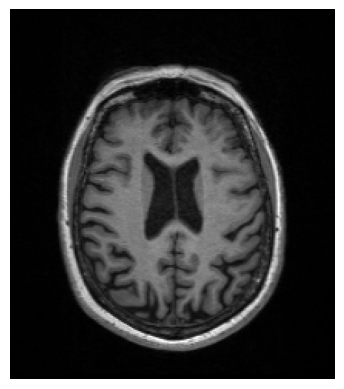

In [3]:
img = cv2.imread('../data/ventricle_segmentation/0.png', flags=cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
#plt.colorbar()
plt.axis('off')
plt.show()


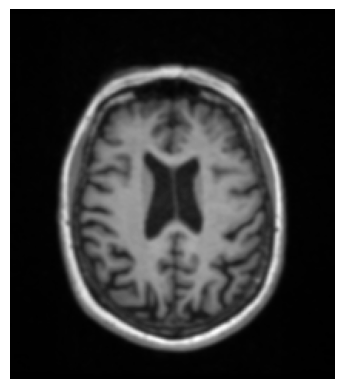

In [4]:
img_gauss = cv2.GaussianBlur(img, (5,5), 0)
plt.imshow(img_gauss, cmap='gray')
plt.axis('off')
plt.show()

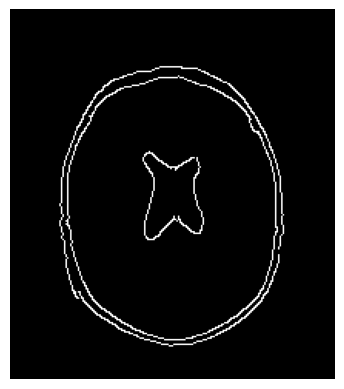

In [5]:
img_canny = cv2.Canny(img_gauss, 125, 350)
plt.imshow(img_canny, cmap='gray')
plt.axis('off')
plt.show()

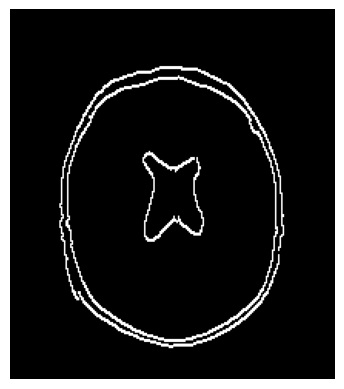

In [6]:
img_dilate = cv2.dilate(img_canny,(-1, -1), 3)

plt.imshow(img_dilate, cmap='gray')
plt.axis('off')
plt.show()

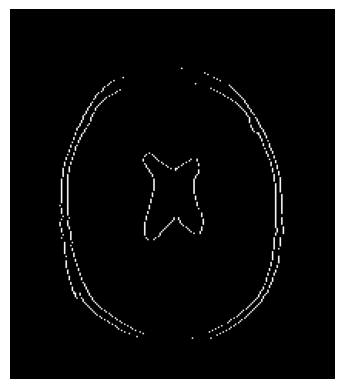

In [7]:
img_erode = cv2.erode(img_canny, kernel=(3,3))

plt.imshow(img_erode, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
element

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)

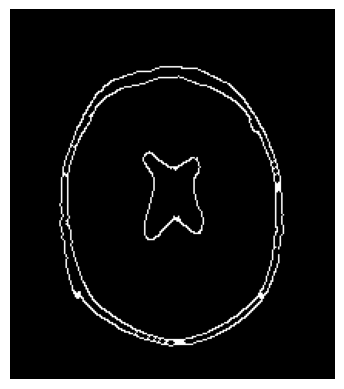

In [9]:
img_closing = cv2.morphologyEx(img_canny, cv2.MORPH_CLOSE, element)
plt.imshow(img_closing, cmap='gray')
plt.axis('off')
plt.show()


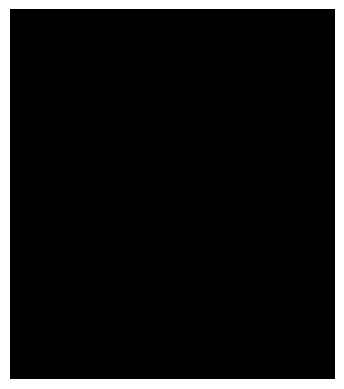

In [10]:
img_opening = cv2.morphologyEx(img_canny, cv2.MORPH_OPEN, element)
plt.imshow(img_opening, cmap='gray')
plt.axis('off')
plt.show()

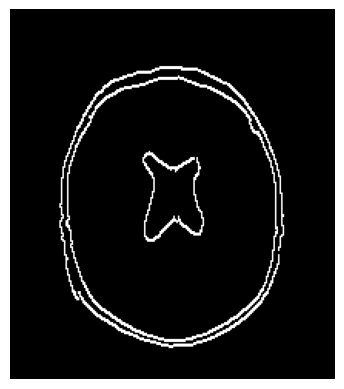

In [11]:
img_dilate_bgr = cv2.cvtColor(img_dilate, cv2.COLOR_GRAY2BGR)
plt.imshow(img_dilate_bgr, cmap='gray')
#plt.colorbar()
plt.axis('off')
plt.show()

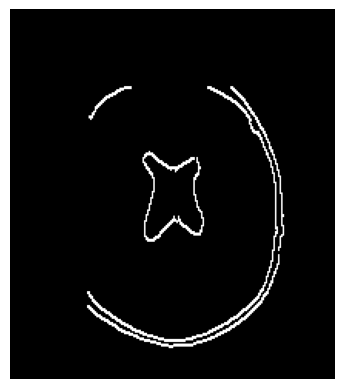

In [12]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,450,290)
cv2.grabCut(img_dilate_bgr, mask, rect, bgdModel, fgdModel, 5, cv2.GC_BGD)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img_result = img_dilate_bgr * mask2[:, :, np.newaxis]
plt.imshow(img_result, cmap='gray')
#plt.colorbar()
plt.axis('off')
plt.show()

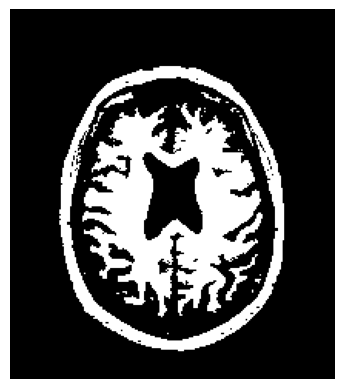

In [27]:
# newmask is the mask image I manually labelled
img = cv2.imread('../data/ventricle_segmentation/0.png')
newmask = cv2.imread('../data/ventricle_segmentation/0.png', cv2.IMREAD_GRAYSCALE)

# wherever it is marked white (sure foreground), change mask=1
# wherever it is marked black (sure background), change mask=0
mask = np.zeros(img.shape[:2],np.uint8)
#print(newmask.mean())
mask[newmask == 0] = 0
#mask[newmask == 255] = 1
mask[newmask > 80] = 1

#mask = cv2.bitwise_not(mask)

plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()


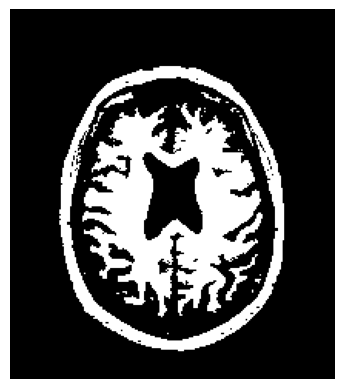

In [39]:
mask, bgdModel, fgdModel = cv2.grabCut(img, mask, None,bgdModel,fgdModel,5,cv2.GC_FGD)
#mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()



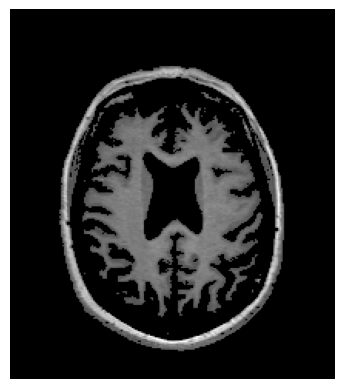

In [22]:
img_result = img*mask[:,:,np.newaxis]
plt.imshow(img_result)
plt.axis('off')
plt.show()

final grabcut:

In [3]:
def grabcut(path:str):
    # Load the image
    img = cv2.imread(path)
    #cv2.imshow("Input", img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #cv2.imshow("Input", gray)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Apply Gaussian blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    #cv2.imshow("Input", blur)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Threshold the image
    ret, thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #thresh[thresh==255] = 1
    print(np.unique(thresh))
    #cv2.imshow("Input", thresh)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Perform morphological operations to remove noise and fill holes
    kernel = np.ones((3,3), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=5)
    #cv2.imshow("Input", closing)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=5)
    #cv2.imshow("Input", opening)
    #cv2.waitKey(0)
    #opening = cv2.bitwise_not(opening)
    #cv2.imshow("Input", opening)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    # Find contours
    contours, _ = cv2.findContours(opening, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the region of interest (ROI)
    mask = np.zeros(img.shape[:2], np.uint8) # np.zeros_like(opening)
    #cv2.fillPoly(mask, [np.array([(50, 200), (150, 100), (250, 200), (150, 300)])], (255, 255, 255))
    #cv2.imshow("Input", mask)
    #cv2.waitKey(0)

    #mask[mask == 255] = 1

    # Perform GrabCut on the ROI
    # Draw contour on mask
    for i in range(0, len(contours)):
        if cv2.contourArea(contours[i]) < 10000:
            #cell_count += 1
            cv2.drawContours(mask, contours, i, (255, 255, 255), cv2.FILLED)
        i += 1
    #cv2.drawContours(mask, contours, -1, (255, 255, 255), cv2.FILLED)
    #cv2.imshow("Input", mask)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Define background and foreground models
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Define rectangle
    rect = None #cv2.boundingRect(contours[-1])
    mask[mask==255] = 1
    #print(np.unique(mask))
    mask, bgdModel, fgdModel = cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iterCount=5, mode=cv2.GC_PR_FGD)

    # Extract the foreground from the mask
    foreground_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
    foreground = cv2.bitwise_and(img, img, mask=foreground_mask)

    # Display the results
    #cv2.imshow("Input", img)
    #cv2.imshow("Foreground", foreground)
    #cv2.waitKey(0)
    cv2.destroyAllWindows()

    plt.figure()
    f, axarr = plt.subplots(2,3)
    f.set_size_inches(18, 10)
    f.set_dpi(100)

    axarr[0][0].imshow(thresh, cmap='gray')
    axarr[0][1].imshow(opening, cmap='gray')
    axarr[0][2].imshow(mask, cmap='gray')
    #axarr[1][1].imshow(foreground_mask, cmap='gray')
    axarr[1][0].imshow(img, cmap='gray')
    axarr[1][2].imshow(foreground, cmap='gray')

    axarr[0][0].set_title('OTSU thresholding')
    axarr[0][1].set_title('Morphology op.')
    axarr[0][2].set_title('Mask')
    #axarr[1][0].set_title('Foreground mask')
    axarr[1][0].set_title('Input')
    axarr[1][2].set_title('Foreground')

    axarr[0][0].axis('off')
    axarr[0][1].axis('off')
    axarr[0][2].axis('off')
    axarr[1][0].axis('off')
    axarr[1][1].axis('off')
    axarr[1][2].axis('off')

    plt.show()


[  0 255]


<Figure size 640x480 with 0 Axes>

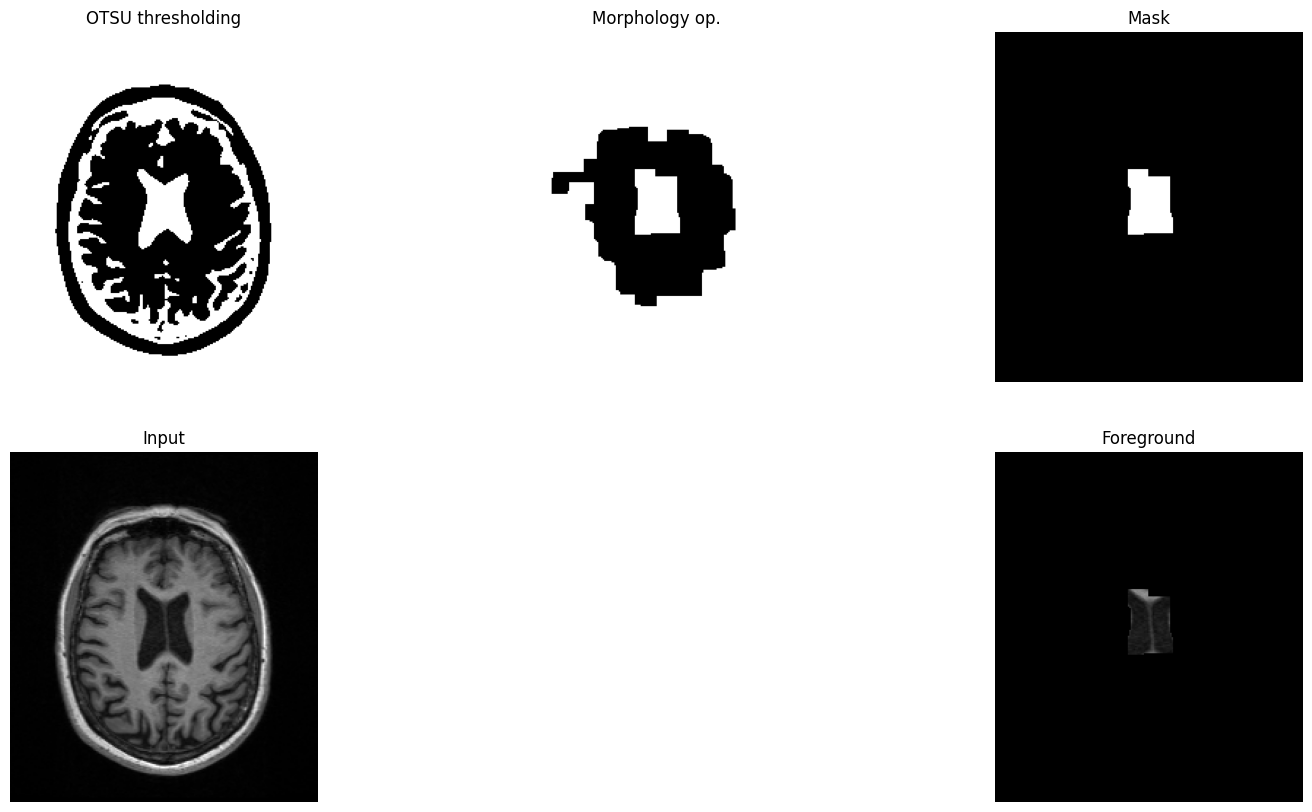

In [4]:
grabcut('../data/ventricle_segmentation/0.png')

## VOC12 dataset segmentation

JPEG images: [link](https://drive.google.com/file/d/1MTgdBUwwBljzHIGz3bIqdLfu4qPx-PuP/view) 

Ground truth labels: [link](https://drive.google.com/file/d/1lR-Ihrg7yE0YVS9PxZTW-_XT6C8rZEnc/view)

Propose a simple method for object segmentation. Pick 1-2 images from the provided dataset. You may use one or multiple segmentation methods such as:

    grabcut

    superpixel segmentation

    floodfill

    thresholding

    and so on..

Use provided ground truth label to compute Dice Score with your prediction (you may chose only 1 specific object for segmentation in case of multiple objects presented in the image)

In [322]:
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def dice_score(true, prediction, max_value:int=255):
    """
    2 * |A ∩ B| / (|A| + |B|)
    """
    return 2.0 * np.sum(prediction[true==max_value]) / (true.sum() + prediction.sum())
    #return 2 * (np.logical_and(true, prediction).sum()) / (true.sum() + prediction.sum())

In [317]:
def binarize_ground_truth(true_path:str):
    """
    
    """
    true = cv2.imread(true_path)
    true = cv2.cvtColor(true, cv2.COLOR_BGR2GRAY)
    threshold_value = 0
    max_value = 255
    return cv2.threshold(true, threshold_value, max_value, cv2.THRESH_BINARY)[1]

In [332]:
def grabcut(img_path:str, true_path:str):
    # Load the image
    img = cv2.imread(img_path)
    true = binarize_ground_truth(true_path)
    #cv2.imshow("Input", img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #cv2.imshow("Input", gray)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Apply Gaussian blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    #cv2.imshow("Input", blur)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Threshold the image
    ret, thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #thresh[thresh==255] = 1
    #cv2.imshow("Input", thresh)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Perform morphological operations to remove noise and fill holes
    kernel = np.ones((3,3), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=5)
    #cv2.imshow("Input", closing)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=5)
    #cv2.imshow("Input", opening)
    #cv2.waitKey(0)
    #opening = cv2.bitwise_not(opening)
    #cv2.imshow("Input", opening)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    # Find contours
    contours, _ = cv2.findContours(opening, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the region of interest (ROI)
    mask = np.zeros(img.shape[:2], np.uint8) # np.zeros_like(opening)
    #cv2.fillPoly(mask, [np.array([(50, 200), (150, 100), (250, 200), (150, 300)])], (255, 255, 255))
    #cv2.imshow("Input", mask)
    #cv2.waitKey(0)

    #mask[mask == 255] = 1

    # Perform GrabCut on the ROI
    # Draw contour on mask
    for i in range(0, len(contours)):
        if cv2.contourArea(contours[i]) > 1000:
            #cell_count += 1
            cv2.drawContours(mask, contours, i, (255, 255, 255), cv2.FILLED)
        i += 1
    #cv2.drawContours(mask, contours, -1, (255, 255, 255), cv2.FILLED)
    #cv2.imshow("Input", mask)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Define background and foreground models
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Define rectangle
    rect = None #cv2.boundingRect(contours[-1])
    mask[mask==255] = 1
    #print(np.unique(mask))
    mask, bgdModel, fgdModel = cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iterCount=5, mode=cv2.GC_PR_FGD)

    # Extract the foreground from the mask
    foreground_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
    foreground = cv2.bitwise_and(img, img, mask=foreground_mask)

    # Display the results
    #cv2.imshow("Input", img)
    #cv2.imshow("Foreground", foreground)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    mask[mask == 1] = 255

    print(f'Dice score is {dice_score(true, mask)}')

    plt.figure()
    f, axarr = plt.subplots(2,3)
    f.set_size_inches(18, 10)
    f.set_dpi(100)

    axarr[0][0].imshow(thresh, cmap='gray')
    axarr[0][1].imshow(opening, cmap='gray')
    axarr[0][2].imshow(mask, cmap='gray')
    axarr[1][1].imshow(true, cmap='gray')
    axarr[1][0].imshow(img, cmap='gray')
    axarr[1][2].imshow(foreground, cmap='gray')

    axarr[0][0].set_title('OTSU thresholding')
    axarr[0][1].set_title('Morphology op.')
    axarr[0][2].set_title('Mask')
    axarr[1][1].set_title('Ground true')
    axarr[1][0].set_title('Input')
    axarr[1][2].set_title('Foreground')

    axarr[0][0].axis('off')
    axarr[0][1].axis('off')
    axarr[0][2].axis('off')
    axarr[1][0].axis('off')
    axarr[1][1].axis('off')
    axarr[1][2].axis('off')

    plt.show()

Dice score is 0.2069304962659372


<Figure size 640x480 with 0 Axes>

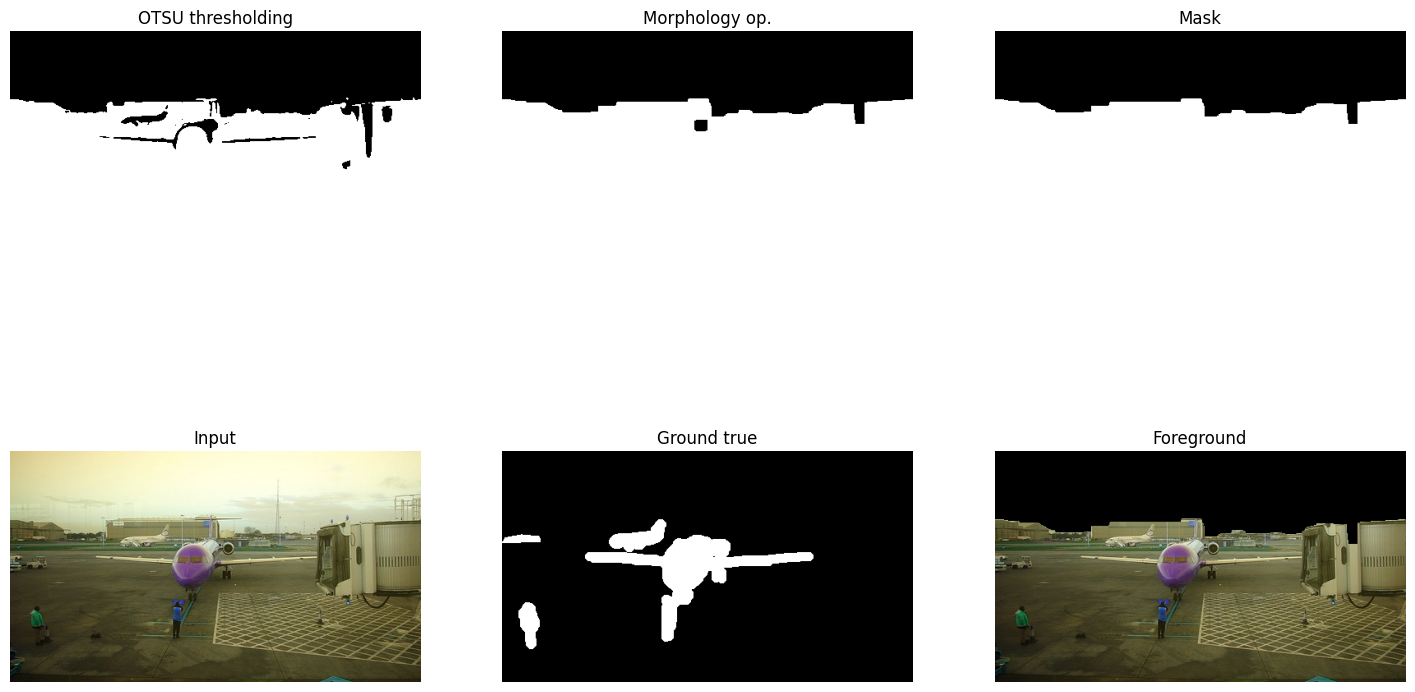

In [333]:
grabcut('../data/JPEGImages/2007_000032.jpg', '../data/SegmentationObject/2007_000032.png')

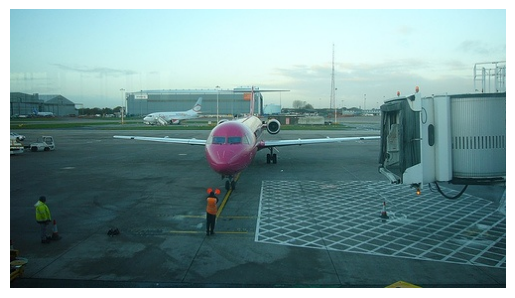

In [219]:
img = cv2.imread('../data/JPEGImages/2007_000032.jpg')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb, cmap='gray')
#plt.colorbar()
plt.axis('off')
plt.show()

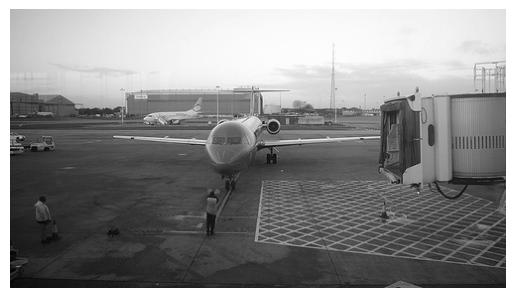

In [220]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.show()

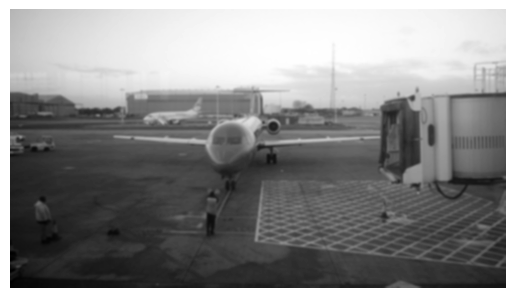

In [265]:
img_gauss = cv2.GaussianBlur(img_gray, (5,5), 0)

#img_rgb = cv2.cvtColor(img_gauss, cv2.COLOR_BGR2RGB)
plt.imshow(img_gauss, cmap='gray')
plt.axis('off')
plt.show()

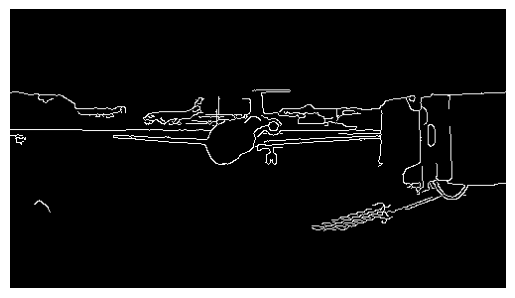

In [266]:
img_canny = cv2.Canny(img_gauss, 50, 300)
plt.imshow(img_canny, cmap='gray')
plt.axis('off')
plt.show()

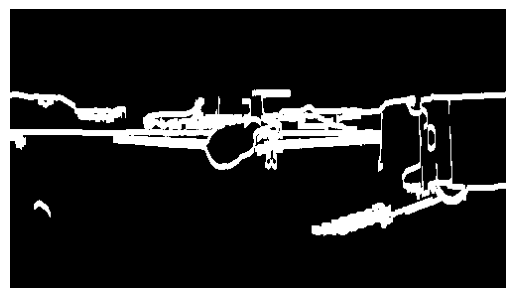

In [267]:
img_dilate = cv2.dilate(img_canny,(7, 7), iterations=5)

plt.imshow(img_dilate, cmap='gray')
plt.axis('off')
plt.show()

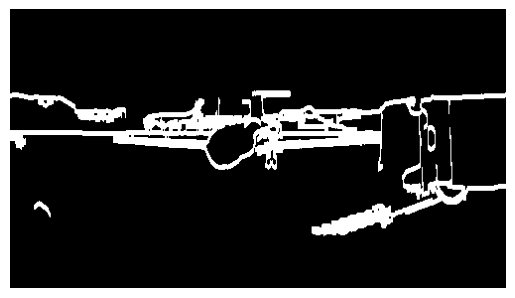

In [268]:
img_erode = cv2.erode(img_dilate, kernel=(11,11))

plt.imshow(img_erode, cmap='gray')
plt.axis('off')
plt.show()

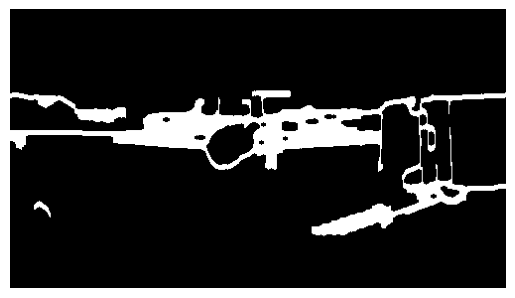

In [269]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

img_closing = cv2.morphologyEx(img_erode, cv2.MORPH_CLOSE, element, iterations=1)
plt.imshow(img_closing, cmap='gray')
plt.axis('off')
plt.show()


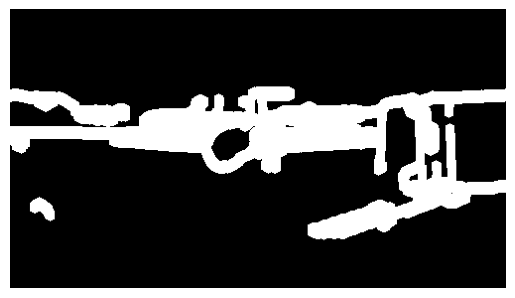

In [270]:
img_closing2 = cv2.morphologyEx(img_closing, cv2.MORPH_DILATE, element, iterations=2)
plt.imshow(img_closing2, cmap='gray')
plt.axis('off')
plt.show()


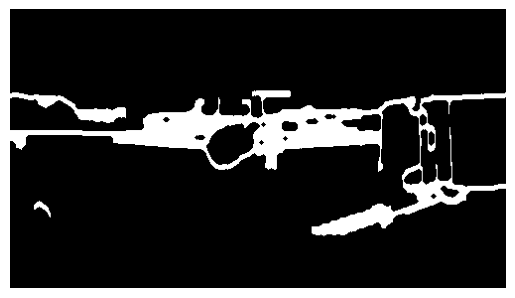

In [271]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

img_closing = cv2.morphologyEx(img_closing, cv2.MORPH_CLOSE, element, iterations=2)
plt.imshow(img_closing, cmap='gray')
plt.axis('off')
plt.show()


In [316]:
from typing import Any, Tuple

def contours(img: cv2.Mat, img_input: cv2.Mat, mode: Any, method: int) -> Tuple[cv2.Mat, cv2.Mat]:
    """
    Countour analysis
    :param: img - original image
    :param: img_input - image after morphological operation
    :param: mode - mode in cv2.findContours
    :param: method - method in cv2.findContours
    :returns: tuple of resulting image and mask
    """
    img_result = img.copy()
    prediction_ = img_input.copy()
    img_contours, _ = cv2.findContours(img_input, mode, method)

    for i in range(0, len(img_contours)):
        if cv2.contourArea(img_contours[i]) > 10000:
            cv2.drawContours(img_result, img_contours, i, (0, 255, 0), 4)
            cv2.drawContours(prediction_, img_contours, i, (0, 255, 0), 4)
        i += 1
        
    return img_result, prediction_

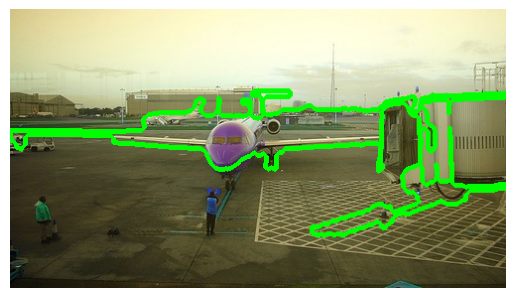

In [318]:
img_result, prediction = contours(img, img_closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

true = binarize_ground_truth('../data/SegmentationObject/2007_000032.png')
plt.imshow(img_result, cmap='gray')
plt.axis('off')
plt.show()

#print(dice_score(true, true))

In [319]:
np.unique(true)

array([  0, 255], dtype=uint8)

In [320]:
np.unique(prediction)

array([  0, 255], dtype=uint8)

In [321]:
# Dice similarity function
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

dice_score = dice(prediction, true, k = 255) 
print ("Dice Similarity: {}".format(dice_score))

Dice Similarity: 0.4154199082385797


In [285]:
2 * np.sum(prediction[true==1]) #np.logical_and(true, prediction).sum()

0.0

In [283]:
true.sum() + prediction.sum()

5113260

In [281]:
2 * () / ()

0.0016290976793669793

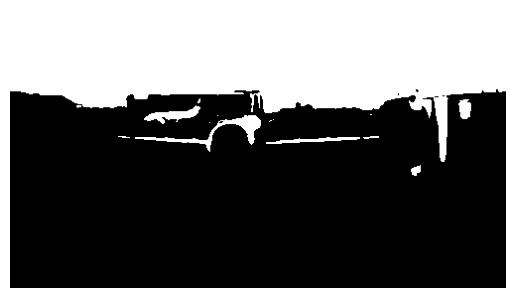

In [109]:
# Convert the image to grayscale
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to create a binary mask
ret, binary_mask = cv2.threshold(img_gauss, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.show()

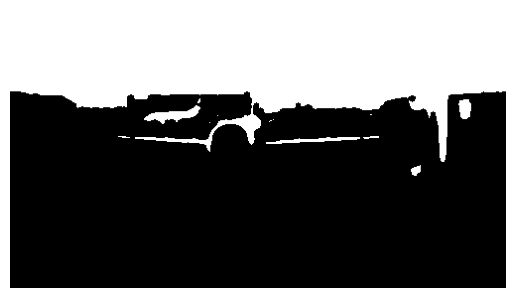

In [112]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.show()

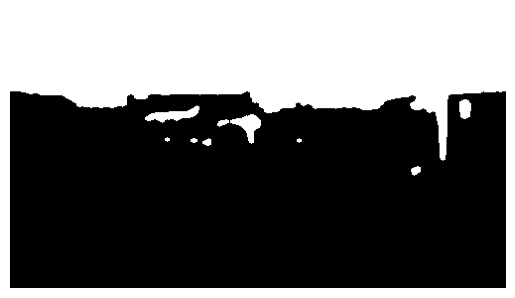

In [113]:
# Apply morphological operations to remove small noise and fill holes
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.show()

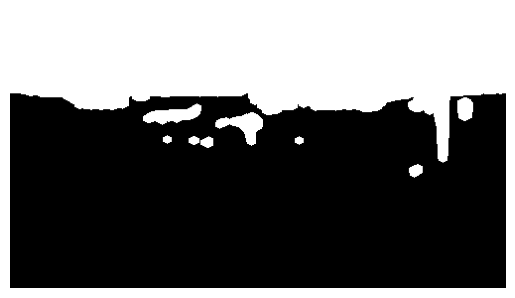

In [114]:
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_DILATE, kernel)
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.show()

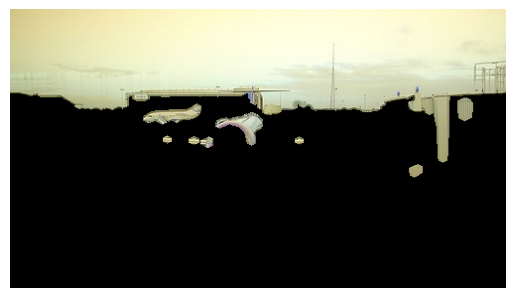

In [116]:

# Create a color mask by applying the binary mask to the original image
color_mask = cv2.bitwise_and(img, img, mask=binary_mask)
plt.imshow(color_mask, cmap='gray')
plt.axis('off')
plt.show()

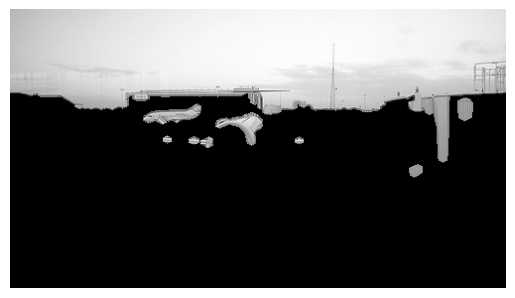

In [118]:
# Apply the watershed algorithm to segment the image
gray = cv2.cvtColor(color_mask, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

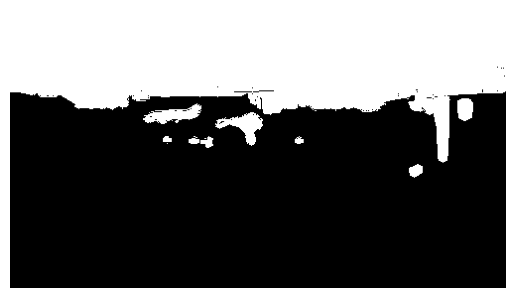

In [120]:
ret, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.show()

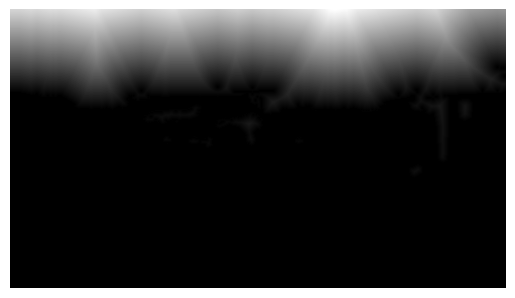

In [122]:
dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)
plt.imshow(dist_transform, cmap='gray')
plt.axis('off')
plt.show()

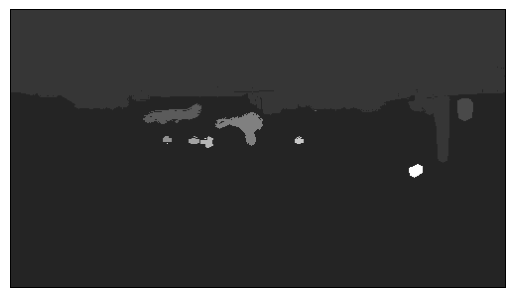

In [124]:
ret, markers = cv2.connectedComponents(binary_mask)
markers = markers + 1
markers[dist_transform > 0.7 * dist_transform.max()] = 0
markers = cv2.watershed(color_mask, markers)
plt.imshow(markers, cmap='gray')
plt.axis('off')
plt.show()

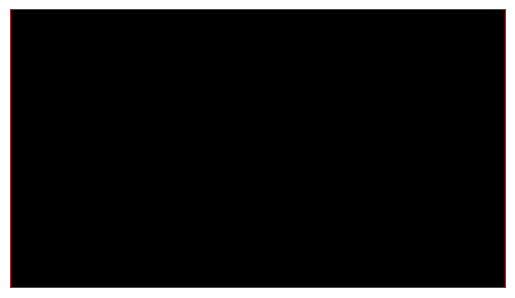

In [132]:
# Overlay the segmentation result onto the original image
overlay = np.zeros_like(img)
overlay[markers == -1] = [255, 0, 0]
plt.imshow(overlay, cmap='gray')
plt.axis('off')
plt.show()

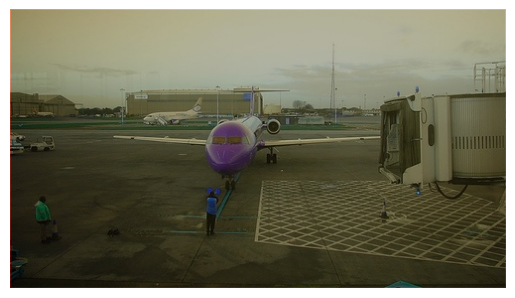

In [133]:
result = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)
plt.imshow(result, cmap='gray')
plt.axis('off')
plt.show()

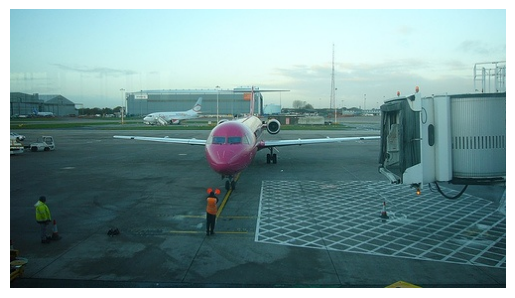

In [91]:
img = cv2.imread('../data/JPEGImages/2007_000032.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb, cmap='gray')
plt.axis('off')
plt.show()

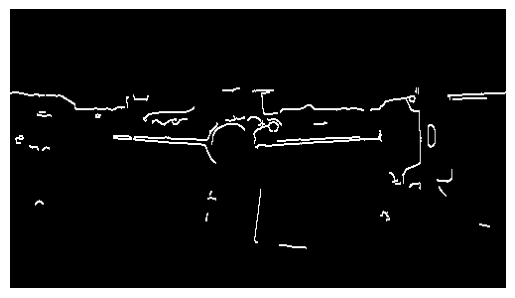

In [103]:
# newmask is the mask image I manually labelled
#img = cv2.imread('../data/ventricle_segmentation/0.png')
newmask = cv2.imread('../data/JPEGImages/2007_000032.jpg', cv2.IMREAD_GRAYSCALE)

# wherever it is marked white (sure foreground), change mask=1
# wherever it is marked black (sure background), change mask=0
#img_dilate_bgr = cv2.cvtColor(img_dilate, cv2.COLOR_GRAY2BGR)
mask = np.zeros(img.shape[:2],np.uint8)
#print(newmask.mean())
mask[newmask == 0] = 0
#mask[newmask == 255] = 1
mask[newmask == 255] = 1
plt.imshow(img_result)
plt.axis('off')
plt.show()

In [119]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,450,290)
print(img.shape)
mask, bgdModel, fgdModel = cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5,cv2.GC_FGD)
#mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img_result = img_dilate_bgr*mask[:,:,np.newaxis]
plt.imshow(img_result)
plt.axis('off')
plt.show()

(281, 500, 3)


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/grabcut.cpp:386: error: (-215:Assertion failed) !bgdSamples.empty() && !fgdSamples.empty() in function 'initGMMs'


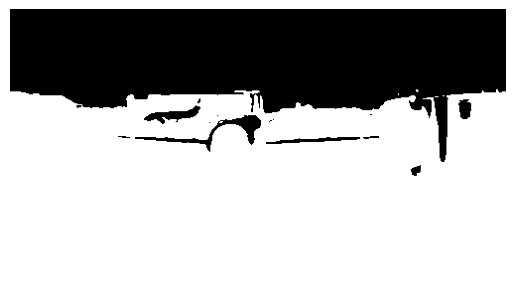

In [77]:
# https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
ret, thresh = cv2.threshold(img_gauss, 127, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#thres = cv2.Canny(img_gray)
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

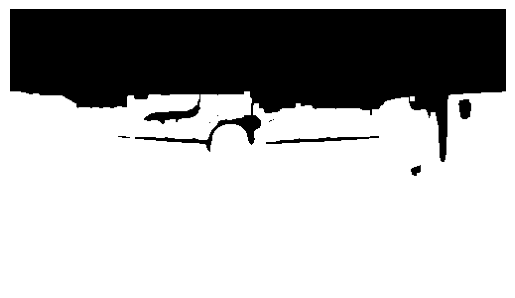

In [78]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
plt.imshow(opening, cmap='gray')
plt.axis('off')
plt.show()

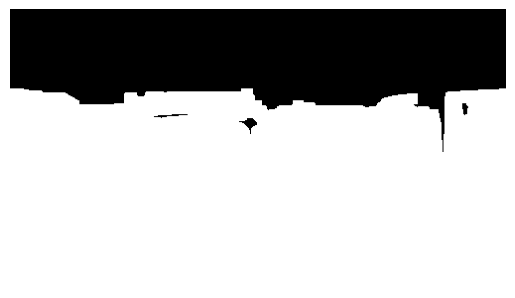

In [79]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.imshow(sure_bg, cmap='gray')
plt.axis('off')
plt.show()

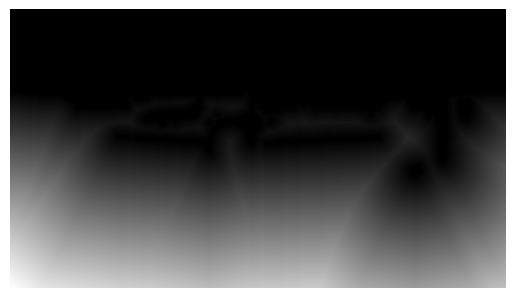

In [80]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
plt.imshow(dist_transform, cmap='gray')
plt.axis('off')
plt.show()

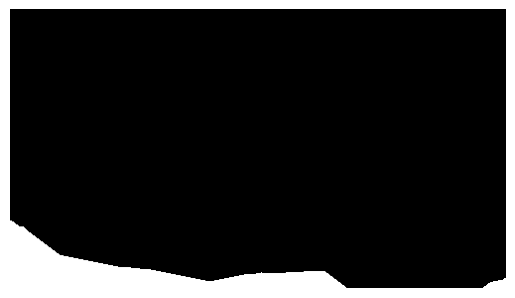

In [81]:
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
plt.imshow(sure_fg, cmap='gray')
plt.axis('off')
plt.show()


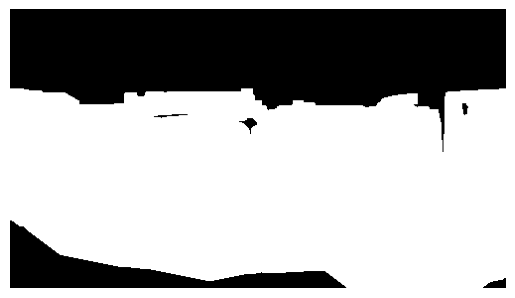

In [82]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown, cmap='gray')
plt.axis('off')
plt.show()

skus prerobiť markers, napr spočítať superpixely a hodiť do watershade

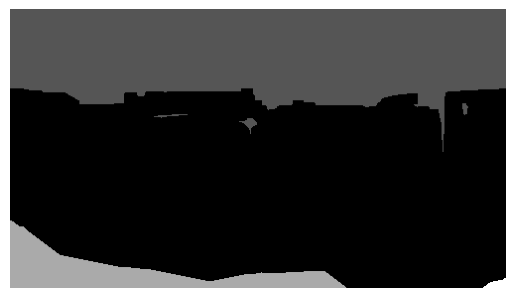

In [83]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.imshow(markers, cmap='gray')
plt.axis('off')
plt.show()

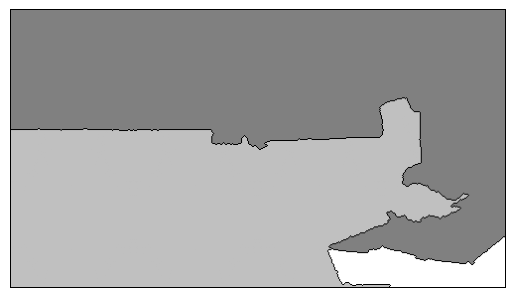

In [84]:
markers = cv2.watershed(img,markers)
plt.imshow(markers, cmap='gray')
plt.axis('off')
plt.show()

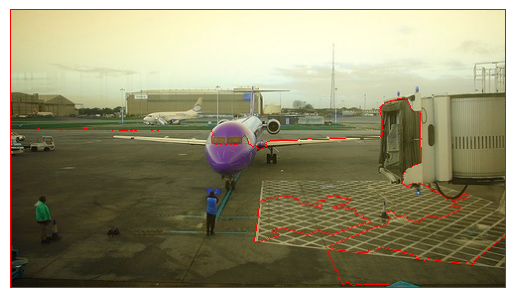

In [85]:
img[markers == -1] = [255,0,0]
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

superpixel

[254 255]


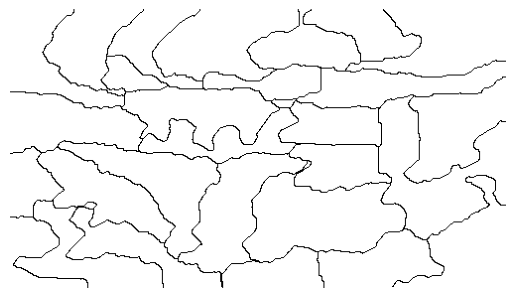

In [108]:
# Load the image in grayscale
img = cv2.imread('../data/JPEGImages/2007_000032.jpg') #, cv2.IMREAD_GRAYSCALE)

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Adjust the parameters as needed
img_width = gray.shape[1]
img_height = gray.shape[0]
img_channels = 1  # for grayscale image
num_superpixels = 100
num_levels = 8
prior = 8
histogram_bins = 50
double_step = True

# Create SuperpixelSEEDS object
seeds = cv2.ximgproc.createSuperpixelSEEDS(img_width, 
                                           img_height, 
                                           img_channels, 
                                           num_superpixels, 
                                           num_levels, 
                                           prior, 
                                           histogram_bins, 
                                           double_step)

# Initialize superpixels
seeds.iterate(gray, 10)

#
contour_mask = seeds.getLabelContourMask()
contour_mask[contour_mask == 255] = 1

contour_mask = cv2.bitwise_not(contour_mask)

print(np.unique(contour_mask))
plt.imshow(contour_mask, cmap='gray')
plt.axis('off')
plt.show()

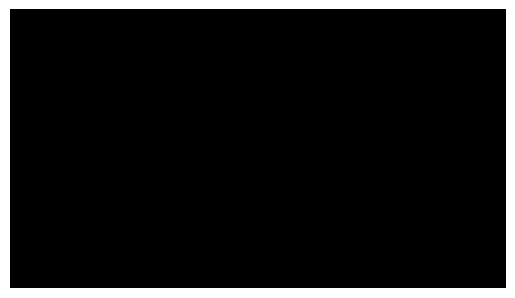

In [109]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(contour_mask,cv2.DIST_L2,5)

plt.imshow(dist_transform, cmap='gray')
plt.axis('off')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


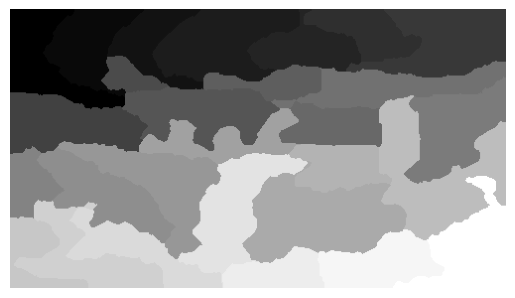

In [116]:
# Get the labels
labels = seeds.getLabels()
print(np.unique(labels))

#labels = cv2.bitwise_not(labels)

plt.imshow(labels, cmap='gray')
plt.axis('off')
plt.show()
# Convert the image to a supported depth
#labels = cv2.convertScaleAbs(labels)

In [88]:
labels.shape

(281, 500)

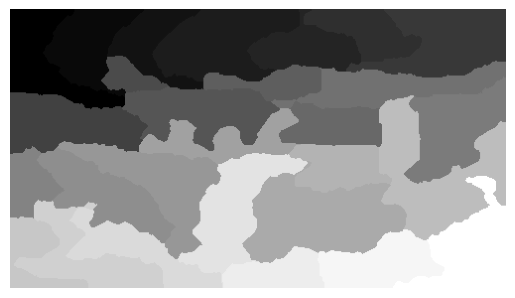

In [153]:
# Apply color mapping
#mask = cv2.cvtColor(labels, cv2.COLOR_GRAY2BGR)
#mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)

# Create a mask for superpixels with contours
mask = np.zeros_like(contour_mask, dtype=np.int32)
for i in range(num_superpixels):
    #print(i)
    mask[labels == i] = i

#mask = mask.astype("uint8")
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

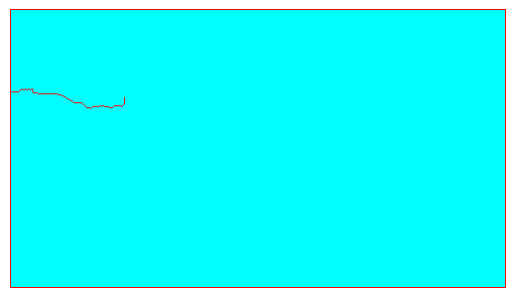

In [154]:
# Create markers for watershed algorithm
#markers = np.zeros_like(gray)
#markers[seeds.getLabelContourMask()] = 255

# Set the markers for watershed segmentation
#markers[contour_mask] = 255
#markers[segs.getLabel() == -1] = 0
#markers[labels == -1] = 0
#markers[markers == 255] = 1

# Color the segments in the mask image
#mask2 = np.zeros_like(gray)
#mask2[markers == -1] = [0, 0, 255]
#mask2[markers != -1] = [255, 255, 255]

# Convert the grayscale image to CV_32SC1
#markers = markers.astype('int32')
#print(markers.shape)

# Apply watershed algorithm
markers = cv2.watershed(img, mask)

# Create a colored mask
colored_mask = np.zeros_like(img)
colored_mask[markers == -1] = [255, 0, 0]  # mark watershed boundaries in red
for i in range(num_superpixels):
    colored_mask[markers == i] = [0, 255, 255]  # mark segmented regions in white

plt.imshow(colored_mask, cmap='gray')
plt.axis('off')
plt.show()

In [44]:
img[markers == -1] = [0, 0, 255]

# Display the result
cv2.imshow('Superpixel segmentation', colored_mask)
#cv2.imshow("markers", markers)
cv2.imshow("Result", img)
cv2.waitKey(0)
cv2.destroyAllWindows()